In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import json
import gensim.downloader as api
from sklearn.metrics import f1_score
import numpy as np
from gensim.models import KeyedVectors
import pickle
import matplotlib.pyplot as plt

In [2]:
with open('Json Task1/NER_train.json', 'r') as f:
    task1_train_data = json.load(f)

with open('Json Task1/NER_val.json', 'r') as f:
    task1_val_data = json.load(f)

with open('Json Task1/NER_test.json', 'r') as f:
    task1_test_data = json.load(f)

with open('Json Task2/ATE_train.json', 'r') as f:
    task2_train_data = json.load(f)

with open('Json Task2/ATE_val.json', 'r') as f:
    task2_val_data = json.load(f)

with open('Json Task2/ATE_test.json', 'r') as f:
    task2_test_data = json.load(f)

with open('glove_embedding.pkl', 'rb') as pickle_file:
    glove_embeddings = pickle.load(pickle_file)
    
with open('fast_text_embedding.pkl', 'rb') as pickle_file:
    fast_text_embedding = pickle.load(pickle_file)

with open('word2vec_embeddings.pkl', 'rb') as pickle_file:
    word2vec_embeddings = pickle.load(pickle_file)

bio_mapping_task1 = {'B_ORG': 0, 'I_ORG': 1, 'B_RESPONDENT': 2, 'I_RESPONDENT': 3, 'B_JUDGE': 4, 'I_JUDGE': 5,
               'B_STATUTE': 6, 'I_STATUTE': 7, 'B_OTHER_PERSON': 8, 'I_OTHER_PERSON': 9, 'B_COURT': 10, 'I_COURT': 11,
               'B_GPE': 12, 'I_GPE': 13, 'B_PETITIONER': 14, 'I_PETITIONER': 15, 'B_WITNESS': 16, 'I_WITNESS': 17,
               'B_CASE_NUMBER': 18, 'I_CASE_NUMBER': 19, 'B_PRECEDENT': 20, 'I_PRECEDENT': 21, 'B_DATE': 22, 'I_DATE': 23,
               'B_PROVISION': 24, 'I_PROVISION': 25, 'O': 26}
bio_mapping_task2 = {'O' : 0, 'I' : 1, 'B' : 2}

In [3]:
# word2vec_model = api.load('word2vec-google-news-300')

# word2vec = torch.FloatTensor(word2vec_model.vectors)
# word2vec_u_ = np.concatenate((word2vec, np.zeros((1, 300), dtype = 'float32')), axis = 0)

# # Add an unknown token to the vocabulary
# word_to_index = {word: index for index, word in enumerate(word2vec_model.index_to_key)}
# word_to_index['<unk>'] = len(word_to_index)

# # Example usage
# unknown_token_index = word_to_index['<unk>']

In [9]:
# word2vec_embeddings = {}
# def get_word2vec__dictionary():
#     count = 0
#     data = [task1_train_data, task1_val_data, task1_test_data, task2_train_data, task2_val_data, task2_test_data]
#     for task_data in data:
#         for key in task_data:
#             words = task_data[key]['text'].split(' ')
#             # print(count)
#             count +=1
#             for word in words:
#                 if word not in word2vec_embeddings:
#                     word2vec_embeddings[word] = word2vec_u_[word_to_index.get(word, word_to_index['<unk>'])]

# get_word2vec__dictionary()

# with open('word2vec_embeddings.pkl', 'wb') as pickle_file:
#     pickle.dump(word2vec_embeddings, pickle_file)

In [3]:
def pad_data():
    max_length = 84
    pad_word = 'PAD'

    data = [task1_train_data, task1_val_data, task1_test_data, task2_train_data, task2_val_data, task2_test_data]
    for task_data in data:
        remove_keys = []
        for key in task_data:
            words = task_data[key]['text'].split(' ')
            tags = task_data[key]['labels']
            if(len(words) >= max_length):
                remove_keys.append(key)
                continue
            else:
                for _ in range(len(words), max_length):
                    words.append(pad_word)
                    tags.append('O')   
            task_data[key]['text'] = ' '.join(words)
            task_data[key]['labels'] = tags
        
        for key in remove_keys:
            task_data.pop(key, None)



pad_data()
task1_train_data = {new_key: task1_train_data[old_key] for new_key, (old_key, _) in enumerate(task1_train_data.items())}
task1_val_data = {new_key: task1_val_data[old_key] for new_key, (old_key, _) in enumerate(task1_val_data.items())}
task1_test_data = {new_key: task1_test_data[old_key] for new_key, (old_key, _) in enumerate(task1_test_data.items())}
task2_train_data = {new_key: task2_train_data[old_key] for new_key, (old_key, _) in enumerate(task2_train_data.items())}
task2_val_data = {new_key: task2_val_data[old_key] for new_key, (old_key, _) in enumerate(task2_val_data.items())}
task2_test_data = {new_key: task2_test_data[old_key] for new_key, (old_key, _) in enumerate(task2_test_data.items())}



In [2]:
# fasttext_model_path = "wiki-news-300d-1M-subword.vec"
# fasttext_model = KeyedVectors.load_word2vec_format(fasttext_model_path, binary=False)

# def get_word_embedding(word):
#     if word in fasttext_model:
#         return fasttext_model[word]
#     else:
#         subword_embeddings = [fasttext_model[subword] for subword in fasttext_model.key_to_index if subword in word]
#         if subword_embeddings:
#             return np.mean(subword_embeddings, axis=0)
#         else:
#             return np.zeros(fasttext_model.vector_size)

# fast_text_embedding = {}
# def get_word_vector():
#     count = 0
#     data = [task1_train_data, task1_val_data, task1_test_data, task2_train_data, task2_val_data, task2_test_data]
#     for task_data in data:
#         for key in task_data:
#             words = task_data[key]['text'].split(' ')
#             print(count)
#             count +=1
#             for word in words:
#                 if word not in fast_text_embedding:
#                     word_vector = get_word_embedding(word)
#                     fast_text_embedding[word] = word_vector

# word2vec_embeddings = {}
# def get_word2vec__dictionary():
#     count = 0
#     data = [task1_train_data, task1_val_data, task1_test_data, task2_train_data, task2_val_data, task2_test_data]
#     for task_data in data:
#         for key in task_data:
#             words = task_data[key]['text'].split(' ')
#             # print(count)
#             count +=1
#             for word in words:
#                 if word not in word2vec_embeddings:
#                     word2vec_embeddings[word] = word2vec_u_[word_to_index.get(word, word_to_index['<unk>'])]

# get_word2vec__dictionary()

# get_word_vector()  

# def load_glove_embeddings(file_path):
#     word_embeddings = {}
#     with open(file_path, 'r', encoding='utf-8') as file:
#         for line in file:
#             try:
#                 values = line.split()
#                 word = values[0]
#                 vector = np.array(values[1:], dtype='float32')
#                 word_embeddings[word] = vector
#             except ValueError as e:
#                 print(f"Error processing line: {line}\nError: {e}")
#     return word_embeddings

# glove_file_path = 'glove.840B.300d.txt'  # Adjust the path based on your downloaded file
# glove_embeddings = load_glove_embeddings(glove_file_path)

# g_e = {}
# def get_glove_dictionary(glove_embeddings):
#     count = 0
#     data = [task1_train_data, task1_val_data, task1_test_data, task2_train_data, task2_val_data, task2_test_data]
#     for task_data in data:
#         for key in task_data:
#             words = task_data[key]['text'].split(' ')
#             print(count)
#             count +=1
#             for word in words:
#                 if word not in g_e:
#                     g_e[word] = glove_embeddings.get(word, np.zeros(300, dtype = 'float32'))



# get_glove_dictionary(glove_embeddings)

In [12]:
# import pickle

# with open('glove_embedding.json', 'w') as json_file:
#     json.dump(g_e, json_file)

# with open('fast_text_embedding.json', 'w') as json_file:
#     json.dump(fast_text_embedding, json_file)

# with open('glove_embedding.pkl', 'wb') as pickle_file:
#     pickle.dump(g_e, pickle_file)

# with open('fast_text_embedding.pkl', 'wb') as pickle_file:
#     pickle.dump(fast_text_embedding, pickle_file)


In [4]:

class GRUModel(nn.Module):
    def __init__(self, embedding_dim, output_size):
        super(GRUModel, self).__init__()
        # self.embedding_layer = nn.Embedding.from_pretrained(pretrained_embedding, freeze=True)
        self.gru = nn.GRU(embedding_dim, 32, num_layers=1, batch_first=True)
        # self.fc1 = nn.Linear(128, 64)
        self.fc1 = nn.Linear(32, output_size)

    def forward(self, x):
        # x = self.embedding_layer(x)
        out, _ = self.gru(x)
        out = self.fc1(out)
        # out = self.fc2(out)
        return out

class Task_data(Dataset):
    def __init__(self, data, bio_index, embedding_type):
        self.data = data
        self.length = len(self.data)
        self.bio_index =  bio_index
        self.embedding_type = embedding_type

    def __len__(self):
        return self.length

    def __getitem__(self, index):
        input_sequence = self.data[index]['text'].split(' ')
        sentence_embeddings = []
        if self.embedding_type == "glove":
            sentence_embeddings = [glove_embeddings.get(word, np.zeros(300, dtype = 'float32')) for word in input_sequence]
        elif self.embedding_type == "word2vec":
            sentence_embeddings = [word2vec_embeddings.get(word, np.zeros(300, dtype = 'float32')) for word in input_sequence]
        elif self.embedding_type == "fast_text":
            sentence_embeddings = [np.array(fast_text_embedding.get(word, np.zeros(300, dtype = 'float32')), dtype = 'float32') for word in input_sequence]

        sentence_embeddings = np.array(sentence_embeddings, dtype='float32')
        output_sequence = self.data[index]['labels']
        output_labels = [self.bio_index[word] for word in output_sequence]

        # output_labels = np.array(output_labels, dtype='float32')
        return torch.tensor(sentence_embeddings), torch.tensor(output_labels)

In [5]:
def train_model(task, embedding_type, model, optimizer, criterion, device,  num_epochs = 30, batch_size = 256):
    train_dataloader  = None
    val_dataloader  = None
    test_dataloader = None

    if task == 1:
        train_dataloader = DataLoader(Task_data(task1_train_data, bio_mapping_task1, embedding_type), batch_size=batch_size, shuffle=True)
        val_dataloader =  DataLoader(Task_data(task1_val_data, bio_mapping_task1, embedding_type), batch_size=batch_size, shuffle=True)
    elif task == 2:
        train_dataloader = DataLoader(Task_data(task2_train_data, bio_mapping_task2, embedding_type), batch_size=batch_size, shuffle=True)
        val_dataloader =  DataLoader(Task_data(task2_val_data, bio_mapping_task2, embedding_type), batch_size=batch_size, shuffle=True)


    train_losses = []
    val_losses = []
    train_f1_scores = []
    val_f1_scores = []

    # Training loop
    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        total_train_loss = 0
        all_train_predictions = []
        all_train_targets = []

        for batch_idx, (inputs, targets) in enumerate(train_dataloader):
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            
            loss = 0
            # outputs[:, i, :].shape, 
            for i in range(outputs.size(1)):  # Iterate over time steps
                loss += criterion(outputs[:, i, :], targets[:, i])  
                # Apply CrossEntropyLoss at each time step
                # print(outputs[:, i, :].shape, targets[:, i].shape)
            
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()

            all_train_predictions.extend(outputs.argmax(dim=2).view(-1).cpu().numpy())
            all_train_targets.extend(targets.view(-1).cpu().numpy())


        avg_train_loss = total_train_loss / len(train_dataloader)
        train_losses.append(avg_train_loss)

        train_macro_f1 = f1_score(all_train_targets, all_train_predictions, average='macro')
        train_f1_scores.append(train_macro_f1)
        print(f"Epoch {epoch + 1}, Training Loss: {avg_train_loss}, Training Macro F1-Score: {train_macro_f1}")

        model.eval()  # Set the model to evaluation mode
        total_val_loss = 0
        all_val_predictions = []
        all_val_targets = []

        with torch.no_grad():
            for val_inputs, val_targets in val_dataloader:
                val_inputs, val_targets = val_inputs.to(device), val_targets.to(device)
                val_outputs = model(val_inputs)

                loss = 0
                for i in range(val_outputs.size(1)):  # Iterate over time steps
                    loss += criterion(val_outputs[:, i, :], val_targets[:, i])  

                total_val_loss += loss.item()

                all_val_predictions.extend(val_outputs.argmax(dim=2).view(-1).cpu().numpy())
                all_val_targets.extend(val_targets.view(-1).cpu().numpy())

            avg_val_loss = total_val_loss / len(val_dataloader)
            val_losses.append(avg_val_loss)

            val_macro_f1 = f1_score(all_val_targets, all_val_predictions, average='macro')
            val_f1_scores.append(val_macro_f1)
        print(f"Epoch {epoch + 1},  Validation Loss: {avg_val_loss}, Validation Macro F1-Score: {val_macro_f1}")
    plot_results(train_losses, val_losses, train_f1_scores, val_f1_scores)

    return train_losses, train_f1_scores, val_losses, val_f1_scores

def plot_results(train_losses, val_losses, train_f1_scores, val_f1_scores):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))

    # Plotting Losses
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.title('Training and Validation Losses')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plotting Macro F1-Scores
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_f1_scores, label='Training Macro F1-Score')
    plt.plot(epochs, val_f1_scores, label='Validation Macro F1-Score')
    plt.title('Training and Validation Macro F1-Scores')
    plt.xlabel('Epochs')
    plt.ylabel('Macro F1-Score')
    plt.legend()

    plt.tight_layout()
    plt.show()

def plot_test_results(test_loss, test_macro_f1):
    plt.figure(figsize=(6, 6))
    labels = ['Test Loss', 'Test Macro F1-Score']
    values = [test_loss, test_macro_f1]

    plt.bar(labels, values, color=['blue', 'green'])
    plt.title('Test Results')
    plt.ylabel('Values')
    plt.show()

def test_model(task, embedding_type, model, criterion, device, batch_size = 1):
    test_dataloader = None
    if task == 1:
        test_dataloader =  DataLoader(Task_data(task1_test_data, bio_mapping_task1, embedding_type), batch_size=batch_size, shuffle=False)

    elif task == 2:
        test_dataloader =  DataLoader(Task_data(task2_test_data, bio_mapping_task2, embedding_type), batch_size=batch_size, shuffle=False)

    total_test_loss = 0
    all_test_predictions = []
    all_test_targets = []

    with torch.no_grad():
        for test_inputs, test_targets in test_dataloader:
            test_inputs, test_targets = test_inputs.to(device), test_targets.to(device)
            test_outputs = model(test_inputs)

            loss = 0
            for i in range(test_outputs.size(1)):  # Iterate over time steps
                loss += criterion(test_outputs[:, i, :], test_targets[:, i])  

            total_test_loss += loss.item()

            all_test_predictions.extend(test_outputs.argmax(dim=2).view(-1).cpu().numpy())
            all_test_targets.extend(test_targets.view(-1).cpu().numpy())

        avg_test_loss = total_test_loss / len(test_dataloader)
        test_macro_f1 = f1_score(all_test_targets, all_test_predictions, average='macro')
    print(f'Test Loss: {avg_test_loss}, Test Macro F1-Score: {test_macro_f1}')

Epoch 1, Training Loss: 67.53168503182833, Training Macro F1-Score: 0.035470710911766144
Epoch 1,  Validation Loss: 28.941061193292793, Validation Macro F1-Score: 0.03587939907752928
Epoch 2, Training Loss: 25.393381306382476, Training Macro F1-Score: 0.038840925051418736
Epoch 2,  Validation Loss: 23.313139135187324, Validation Macro F1-Score: 0.042503976601495304
Epoch 3, Training Loss: 21.144810817280753, Training Macro F1-Score: 0.053425100501186346
Epoch 3,  Validation Loss: 19.8683348569003, Validation Macro F1-Score: 0.060209029442447826
Epoch 4, Training Loss: 18.404799852214875, Training Macro F1-Score: 0.06623783078163716
Epoch 4,  Validation Loss: 17.545590313998137, Validation Macro F1-Score: 0.07557314957530453
Epoch 5, Training Loss: 16.554856331622013, Training Macro F1-Score: 0.08258174846368653
Epoch 5,  Validation Loss: 16.04508703405207, Validation Macro F1-Score: 0.08792029647601936
Epoch 6, Training Loss: 15.290242070057353, Training Macro F1-Score: 0.0970134023091

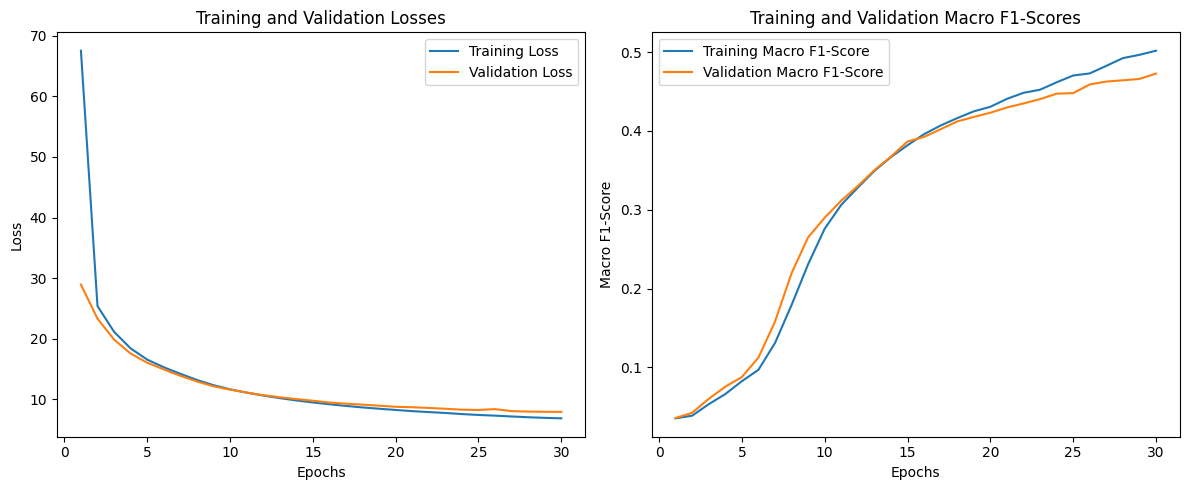

Test Loss: 8.591720511924, Test Macro F1-Score: 0.4751370632763503


In [19]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = GRUModel(300, 27).to(device) 
optimizer = optim.Adam(model.parameters(), lr=0.005)
criterion = nn.CrossEntropyLoss()

train_losses, train_f1_scores, val_losses, val_f1_scores = train_model(task = 1, embedding_type = "fast_text", model = model, num_epochs = 30, optimizer=optimizer, criterion=criterion, batch_size=128, device=device)
test_model(task = 1, embedding_type = "fast_text", model = model, criterion=criterion, device=device)

torch.save(model, 'trained_models/t1_gru_fast_text.pt')



Epoch 1, Training Loss: 62.839574188482565, Training Macro F1-Score: 0.05151450871784259
Epoch 1,  Validation Loss: 20.013822555541992, Validation Macro F1-Score: 0.057130828656031155
Epoch 2, Training Loss: 17.5029007489564, Training Macro F1-Score: 0.10434246028431612
Epoch 2,  Validation Loss: 15.746548652648926, Validation Macro F1-Score: 0.15370476140074366
Epoch 3, Training Loss: 14.357041734163879, Training Macro F1-Score: 0.22087710987430886
Epoch 3,  Validation Loss: 13.55238220908425, Validation Macro F1-Score: 0.2764286614791602
Epoch 4, Training Loss: 12.605815074482901, Training Macro F1-Score: 0.30490134935663626
Epoch 4,  Validation Loss: 12.383091666481711, Validation Macro F1-Score: 0.3329843944885584
Epoch 5, Training Loss: 11.507973921103556, Training Macro F1-Score: 0.34396849316429945
Epoch 5,  Validation Loss: 11.609481378035111, Validation Macro F1-Score: 0.35412435487968635
Epoch 6, Training Loss: 10.694722754056336, Training Macro F1-Score: 0.3635675149219256
E

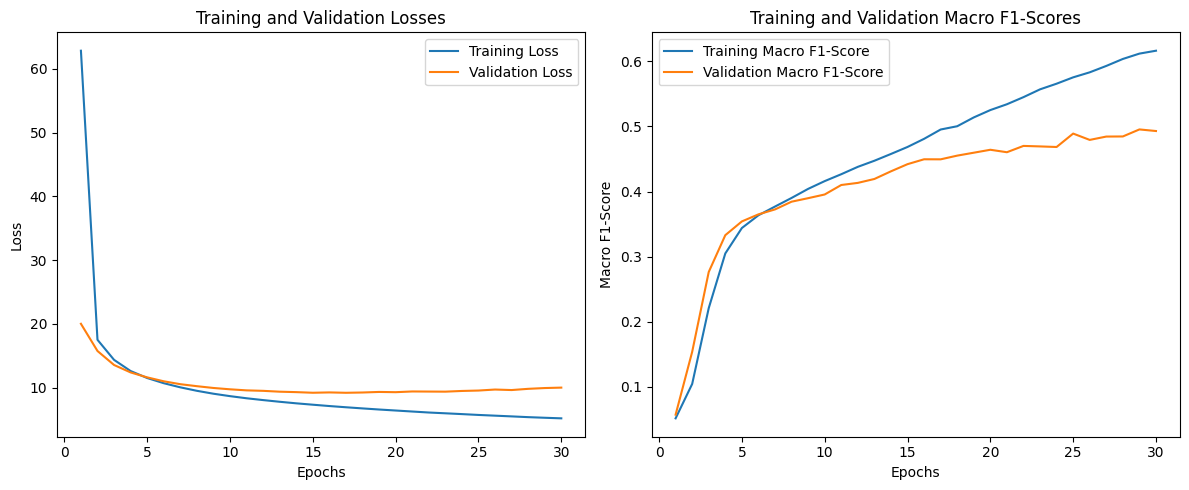

Test Loss: 10.935374668804407, Test Macro F1-Score: 0.4732700735687208


In [20]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = GRUModel(300, 27).to(device) 
optimizer = optim.Adam(model.parameters(), lr=0.005)
criterion = nn.CrossEntropyLoss()
train_losses, train_f1_scores, val_losses, val_f1_scores =  train_model(task = 1, embedding_type = "glove", model = model, optimizer=optimizer,criterion=criterion, device=device, batch_size=128)
test_model(task = 1, embedding_type = "glove", model = model, criterion=criterion, device=device)

torch.save(model, 'trained_models/t1_gru_glove.pt')




Epoch 1, Training Loss: 70.07448346497583, Training Macro F1-Score: 0.03861215389841419
Epoch 1,  Validation Loss: 24.44989551197399, Validation Macro F1-Score: 0.048123313258858366
Epoch 2, Training Loss: 21.803040019801404, Training Macro F1-Score: 0.07106500116198411
Epoch 2,  Validation Loss: 19.79553083939986, Validation Macro F1-Score: 0.09692614673620893
Epoch 3, Training Loss: 18.453062260737184, Training Macro F1-Score: 0.12499707433702247
Epoch 3,  Validation Loss: 17.137956792658027, Validation Macro F1-Score: 0.16176878515920143
Epoch 4, Training Loss: 16.109382770100577, Training Macro F1-Score: 0.18265959971653775
Epoch 4,  Validation Loss: 15.33762229572643, Validation Macro F1-Score: 0.21435540247529358
Epoch 5, Training Loss: 14.502199188607637, Training Macro F1-Score: 0.23678893450218308
Epoch 5,  Validation Loss: 14.062080556696111, Validation Macro F1-Score: 0.26349526924986977
Epoch 6, Training Loss: 13.404937744140625, Training Macro F1-Score: 0.2707681228972112


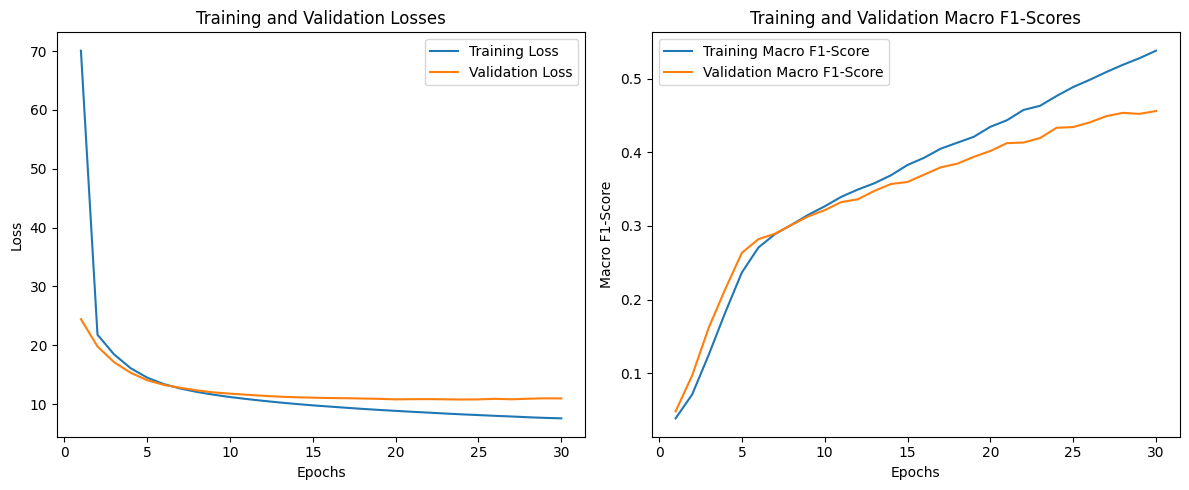

Test Loss: 11.772546144458744, Test Macro F1-Score: 0.44316043606860306


In [21]:
model = GRUModel(300, 27).to(device) 
optimizer = optim.Adam(model.parameters(), lr=0.005)
criterion = nn.CrossEntropyLoss()
train_losses, train_f1_scores, val_losses, val_f1_scores =  train_model(task = 1, embedding_type = "word2vec", model = model, optimizer=optimizer, criterion=criterion, device=device, batch_size=128)
test_model(task = 1, embedding_type = "word2vec", model = model, criterion=criterion, device=device)

torch.save(model, 'trained_models/t1_gru_word2vec.pt')



Epoch 1, Training Loss: 64.41376495361328, Training Macro F1-Score: 0.32919834423063704
Epoch 1,  Validation Loss: 35.82648468017578, Validation Macro F1-Score: 0.329410039232941
Epoch 2, Training Loss: 21.871034383773804, Training Macro F1-Score: 0.32919834423063704
Epoch 2,  Validation Loss: 10.168736457824707, Validation Macro F1-Score: 0.329410039232941
Epoch 3, Training Loss: 11.18895173072815, Training Macro F1-Score: 0.32919834423063704
Epoch 3,  Validation Loss: 11.382387161254883, Validation Macro F1-Score: 0.329410039232941
Epoch 4, Training Loss: 12.033316135406494, Training Macro F1-Score: 0.32919834423063704
Epoch 4,  Validation Loss: 11.120152473449707, Validation Macro F1-Score: 0.329410039232941
Epoch 5, Training Loss: 11.361445188522339, Training Macro F1-Score: 0.32919834423063704
Epoch 5,  Validation Loss: 9.862767219543457, Validation Macro F1-Score: 0.329410039232941
Epoch 6, Training Loss: 9.871655941009521, Training Macro F1-Score: 0.32919834423063704
Epoch 6,  V

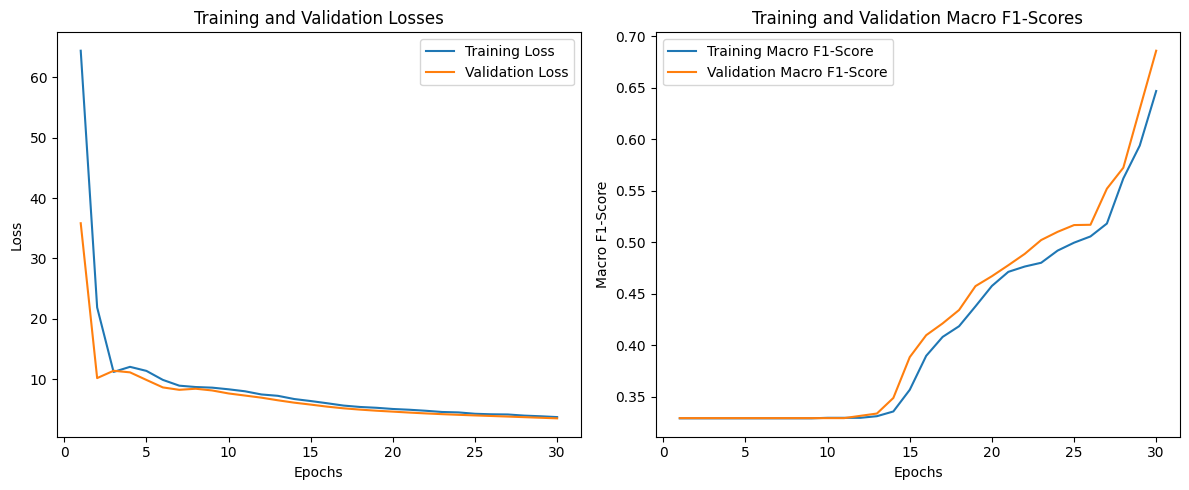

Test Loss: 3.9069089361625475, Test Macro F1-Score: 0.6614762842504465


In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = GRUModel(300, 3).to(device) 
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()
train_losses, train_f1_scores, val_losses, val_f1_scores = train_model(task = 2, embedding_type = "fast_text", model = model, optimizer=optimizer, criterion=criterion, device=device)

test_model(task = 2, embedding_type = "fast_text", model = model, criterion=criterion, device=device)
torch.save(model, 'trained_models/t2_gru_fast_text.pt')



Epoch 1, Training Loss: 88.89432144165039, Training Macro F1-Score: 0.36344533169899
Epoch 1,  Validation Loss: 84.89936065673828, Validation Macro F1-Score: 0.36005661549641327
Epoch 2, Training Loss: 82.75356864929199, Training Macro F1-Score: 0.3582996300385492
Epoch 2,  Validation Loss: 79.24808502197266, Validation Macro F1-Score: 0.34771077749434065
Epoch 3, Training Loss: 77.45109176635742, Training Macro F1-Score: 0.3384691088811667
Epoch 3,  Validation Loss: 74.15245056152344, Validation Macro F1-Score: 0.33591345466903005
Epoch 4, Training Loss: 72.44294929504395, Training Macro F1-Score: 0.3338082620551812
Epoch 4,  Validation Loss: 69.44187927246094, Validation Macro F1-Score: 0.331637684671736
Epoch 5, Training Loss: 67.93250846862793, Training Macro F1-Score: 0.33073465618841263
Epoch 5,  Validation Loss: 64.94657897949219, Validation Macro F1-Score: 0.33165449235339045
Epoch 6, Training Loss: 63.41785430908203, Training Macro F1-Score: 0.331264391335197
Epoch 6,  Validat

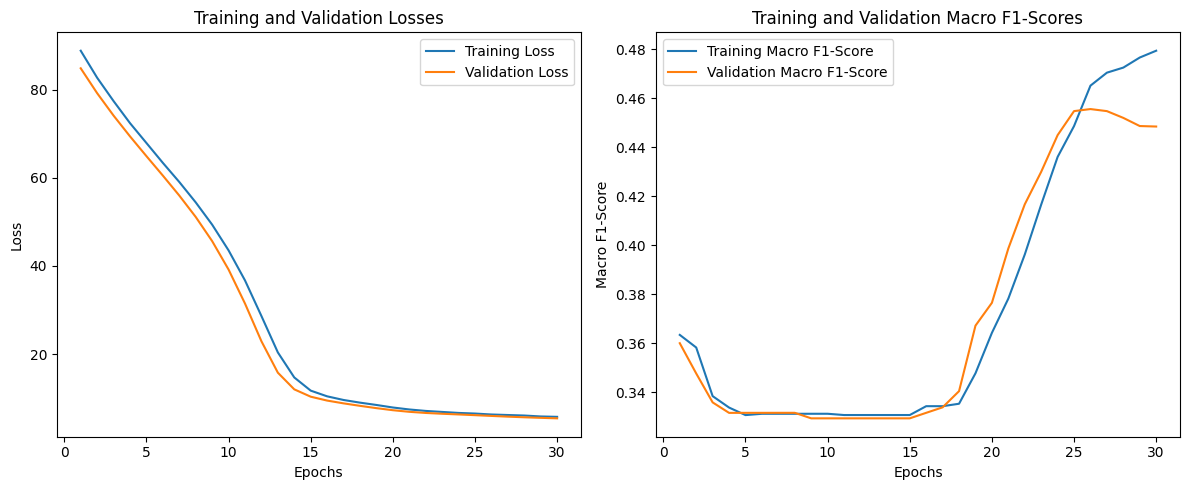

Test Loss: 5.716632490114468, Test Macro F1-Score: 0.46937512168078505


In [10]:
model = GRUModel(300, 3).to(device) 
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
train_losses, train_f1_scores, val_losses, val_f1_scores = train_model(task = 2, embedding_type = "glove", model = model, optimizer=optimizer, criterion=criterion, device=device)
test_model(task = 2, embedding_type = "glove", model = model, criterion=criterion, device=device)
torch.save(model, 'trained_models/t2_gru_glove.pt')




Epoch 1, Training Loss: 80.40921783447266, Training Macro F1-Score: 0.2993349052429003
Epoch 1,  Validation Loss: 63.48116683959961, Validation Macro F1-Score: 0.329410039232941
Epoch 2, Training Loss: 52.09780788421631, Training Macro F1-Score: 0.32920485838577074
Epoch 2,  Validation Loss: 31.507843017578125, Validation Macro F1-Score: 0.329410039232941
Epoch 3, Training Loss: 21.16862416267395, Training Macro F1-Score: 0.32919834423063704
Epoch 3,  Validation Loss: 11.128544807434082, Validation Macro F1-Score: 0.329410039232941
Epoch 4, Training Loss: 11.182279586791992, Training Macro F1-Score: 0.32919834423063704
Epoch 4,  Validation Loss: 10.659231185913086, Validation Macro F1-Score: 0.329410039232941
Epoch 5, Training Loss: 11.37223482131958, Training Macro F1-Score: 0.32919834423063704
Epoch 5,  Validation Loss: 10.491214752197266, Validation Macro F1-Score: 0.329410039232941
Epoch 6, Training Loss: 10.757476806640625, Training Macro F1-Score: 0.33024195455524147
Epoch 6,  Va

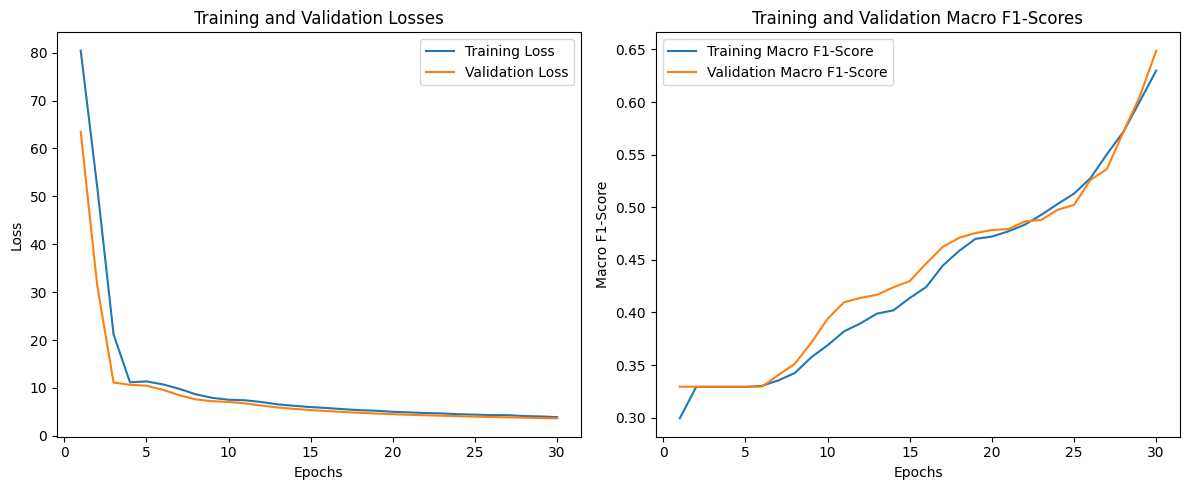

Test Loss: 4.1824229497735095, Test Macro F1-Score: 0.6403280405564583


In [18]:
model = GRUModel(300, 3).to(device) 
optimizer = optim.Adam(model.parameters(), lr=0.005)
criterion = nn.CrossEntropyLoss()
train_losses, train_f1_scores, val_losses, val_f1_scores = train_model(task = 2, embedding_type = "word2vec", model = model, num_epochs=30,optimizer=optimizer, criterion=criterion, device=device)
test_model(task = 2, embedding_type = "word2vec", model = model, criterion=criterion, device=device)
torch.save(model, 'trained_models/t2_gru_word2vec.pt')
